# Week 3: Variational Autoencoders on Anime Faces

For this exercise, you will train a Variational Autoencoder (VAE) using the [anime faces dataset by MckInsey666](https://github.com/bchao1/Anime-Face-Dataset). 

You will train the model using the techniques discussed in class. At the end, you should save your model and download it from Colab so that it can be submitted to the autograder for grading.

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

## Parameters

In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

## Download the Dataset

You will download the Anime Faces dataset and save it to a local directory.

In [ ]:
# make the data directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Prepare the Dataset

Next is preparing the data for training and validation. We've provided you some utilities below.

In [ ]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths
print(get_dataset_slice_paths(download_dir))

def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

['/tmp/anime/images']


You will use the functions above to generate the train and validation sets.

In [ ]:
# get the list containing the image paths
paths = get_dataset_slice_paths("/tmp/anime/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(100).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display Utilities

We've also provided some utilities to help in visualizing the data.

In [ ]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


Let's see some of the anime faces from the validation dataset.

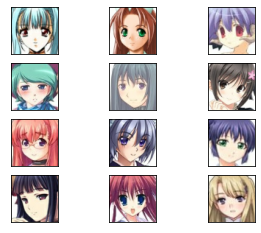

In [ ]:
display_faces(validation_dataset, size=12)

## Build the Model

You will be building your VAE in the following sections. Recall that this will follow and encoder-decoder architecture and can be summarized by the figure below.

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

You will start with the custom layer to provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. Recall the equation to combine these:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [ ]:
class Sampling_layer(tf.keras.layers.Layer):
	def call(self, inputs):
		mu  = inputs[0]
		sigma  = inputs[1]
		epsilon  = tf.random.normal(shape=tf.shape(mu))
		return mu + tf.math.exp(0.5* sigma) * epsilon


### Encoder Layers

Next, please use the Functional API to stack the encoder layers and output `mu`, `sigma` and the shape of the features before flattening. We expect you to use 3 convolutional layers (instead of 2 in the ungraded lab) but feel free to revise as you see fit. Another hint is to use `1024` units in the Dense layer before you get mu and sigma (we used `20` for it in the ungraded lab).

*Note: If you did Week 4 before Week 3, please do not use LeakyReLU activations yet for this particular assignment. The grader for Week 3 does not support LeakyReLU yet. This will be updated but for now, you can use `relu` and `sigmoid` just like in the ungraded lab.*

In [ ]:
  def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space

    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_3.shape -- shape of the features before flattening
    """
    ### START CODE HERE ###

    #TODO
    #todo// 2 2 CNN, each having maxpooling ?
    #todo// Connect it to layer 
    #NOTE 
    #? BEFORE GOING TO LATENT SPACE, SAVE the previous Layer Shape, Fungsine Biar bisa dapet Total Represntasi yang dibutuhkan untuk rekonstruksi
    hidden_layer_1 : Tensor = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),strides=2, activation=tf.nn.relu, padding="same",name="encoder_conv1")(inputs)
    hidden_layer_1 : Tensor = tf.keras.layers.BatchNormalization()(hidden_layer_1)
    hidden_layer_2 : Tensor = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=2, activation=tf.nn.relu, padding="same",name="encoder_conv2")(hidden_layer_1)

    vis : Tensor = tf.keras.layers.BatchNormalization(name="encoder_batchnorm1")(hidden_layer_2) #* YANG INI YA, di return

    fcn : Tensor = tf.keras.layers.Flatten(name="encoder_flatten")(vis)

    fcn : Tensor = tf.keras.layers.Dense(1024, activation=tf.nn.relu, name="encoder_dense1")(fcn)
    fcn : Tensor = tf.keras.layers.BatchNormalization()(fcn)


    mu : Tensor = tf.keras.layers.Dense(latent_dim, activation = "linear")(fcn) #* This shit is real
    sigma : Tensor = tf.keras.layers.Dense(latent_dim, activation= "linear")(fcn)
    
    return mu, sigma, vis.shape

    
    
    
    
    
    
    
    
    
    ### END CODE HERE ###

    # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers

### Encoder Model

You will feed the output from the above function to the `Sampling layer` you defined earlier. That will have the latent representations that can be fed to the decoder network later. Please complete the function below to build the encoder network with the `Sampling` layer.

In [ ]:
  def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening
    """
    ### START CODE HERE ###
    inputs : Layer = tf.keras.layers.Input(shape=input_shape)

    mu, sigma, vis_shape = encoder_layers(inputs, latent_dim)

    z = Sampling_layer()([mu, sigma])

    return tf.keras.Model(inputs, outputs= [mu,sigma,z]), vis_shape
    ### END CODE HERE ###

### Decoder Layers

Next, you will define the decoder layers. This will expand the latent representations back to the original image dimensions. After training your VAE model, you can use this decoder model to generate new data by feeding random inputs.

In [ ]:
  def decoder_layers(inputs, conv_shape):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder 
      conv_shape -- shape of th e features before flattening

    Returns:
      tensor containing the decoded output
    """
    ### START CODE HERE ###
  #NOTE : #? inputs Berupa Laten Space , ini dari Encoder, Latent space ()
  #NOTE : #? Conv_shape isinya : (height, width, channel, filters)

  #todo// Ambil Seluruh Representasi dari si Z
  #todo// Reshape ke bentuk yang sama dengan input layer
  #todo Train dengan Konvolusi Transpose
    hidden_layer_1 : Tensor = tf.keras.layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation=tf.nn.relu,name="decoder_dense1")(inputs)
    reshaped_layer : Tensor = tf.keras.layers.Reshape(target_shape=(conv_shape[1],conv_shape[2], conv_shape[3]))(hidden_layer_1)
    
    transposed = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation=tf.nn.relu, padding="same",name="decoder_Tconv1")(reshaped_layer)
    transposed = tf.keras.layers.BatchNormalization()(transposed)
    transposed = tf.keras.layers.Conv2DTranspose(filters=10, kernel_size=(3,3), strides=2, activation=tf.nn.relu, padding="same",name="decoder_Tconv2")(transposed)
    transposed = tf.keras.layers.BatchNormalization()(transposed)
    transposed = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=1, activation=tf.nn.relu, padding="same",name="decoder_Tconv4")(transposed)
    return transposed
      
    
    

    
    ### END CODE HERE ###
    return x

### Decoder Model

Please complete the function below to output the decoder model.

In [ ]:
  def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening

    Returns:
      model -- the decoder model
    """
    ### START CODE HERE ###
    inputs = tf.keras.layers.Input(shape=latent_dim)
    outputs = decoder_layers(inputs, conv_shape)
    model = tf.keras.models.Model(inputs, outputs)
    ### END CODE HERE ###
    model.summary()
    return model

### Kullback–Leibler Divergence

Next, you will define the function to compute the [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) loss. This will be used to improve the generative capability of the model. This code is already given.


In [ ]:
  def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation

    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together

Please define the whole VAE model. Remember to use `model.add_loss()` to add the KL reconstruction loss. This will be accessed and added to the loss later in the training loop.

In [ ]:
  def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch

    Returns:
      the complete VAE model
    """
    ### START CODE HERE ###
    
    input_layer : Layer = tf.keras.layers.Input(shape=input_shape)
    mu,sigma,z, = encoder(input_layer)
    reconstructed = decoder(z,)

    
    model = tf.keras.Model(inputs=input_layer, outputs=reconstructed)

    # add the KL loss
    loss = kl_reconstruction_loss(input_layer, z, mu, sigma)
    model.add_loss(loss)

    
    
    
    ### END CODE HERE ###
    return model

Next, please define a helper function to return the encoder, decoder, and vae models you just defined.


In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  ### START CODE HERE ###
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

Let's use the function above to get the models we need in the training loop.


In [ ]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
decoder_dense1 (Dense)       (None, 16384)             8404992   
_________________________________________________________________
reshape_7 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_Tconv1 (Conv2DTransp (None, 32, 32, 32)        18464     
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
decoder_Tconv2 (Conv2DTransp (None, 64, 64, 10)        2890      
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 64, 10)        40 

## Train the Model

You will now configure the model for training. We defined some losses, the optimizer, and the loss metric below but you can experiment with others if you like.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

You will generate 16 images in a 4x4 grid to show
progress of image generation. We've defined a utility function for that below.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

You can now start the training loop. You are asked to select the number of epochs and to complete the subection on updating the weights. The general steps are:

* feed a training batch to the VAE model
* compute the reconstruction loss (hint: use the **mse_loss** defined above instead of `bce_loss` in the ungraded lab, then multiply by the flattened dimensions of the image (i.e. 64 x 64 x 3)
* add the KLD regularization loss to the total loss (you can access the `losses` property of the `vae` model)
* get the gradients
* use the optimizer to update the weights


When training your VAE, you might notice that there’s not a lot of variation in the faces. But don’t let that deter you! We’ll test based on how well it does in reconstructing the original faces, and not how well it does in creating new faces.

The training will also take a long time (more than 30 minutes) and that is to be expected. If you used the mean loss metric suggested above, train the model until that is down to around 320 before submitting.


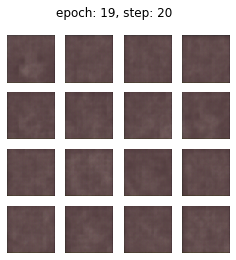

Epoch: 19 step: 20 mean loss = 496.4985
Epoch: 19 step: 21 mean loss = 496.4228
Epoch: 19 step: 22 mean loss = 496.35135
Epoch: 19 step: 23 mean loss = 496.27417
Epoch: 19 step: 24 mean loss = 496.1993
Epoch: 19 step: 25 mean loss = 496.131


In [ ]:
# Training loop. Display generated images each epoch

### START CODE HERE ###
epochs = 70
### END CODE HERE ###

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

# Plot Reconstructed Images


As mentioned, your model will be graded on how well it is able to reconstruct images (not generate new ones). You can get a glimpse of how it is doing with the code block below. It feeds in a batch from the test set and plots a row of input (top) and output (bottom) images. Don't worry if the outputs are a blurry. It will look something like below:

<img src="https://drive.google.com/uc?export=view&id=1OPMbZOxX9fx8tK6CGVbrMaQdgyOiQJIC" width="75%" height="60%"/>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


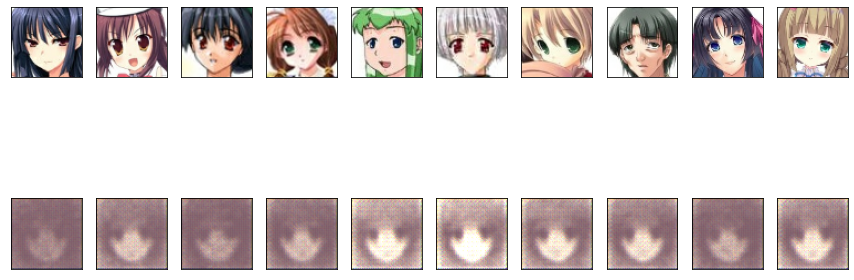

In [215]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

# Plot Generated Images


Using the default parameters, it can take a long time to train your model well enough to generate good fake anime faces. In case you decide to experiment, we provided the code block below to display an 8x8 gallery of fake data generated from your model. Here is a sample gallery generated after 50 epochs.

<img src="https://drive.google.com/uc?export=view&id=1QwElgfg5TY6vCgI1FK6vdI8Bo6UZKfuX" width="75%" height="60%"/>

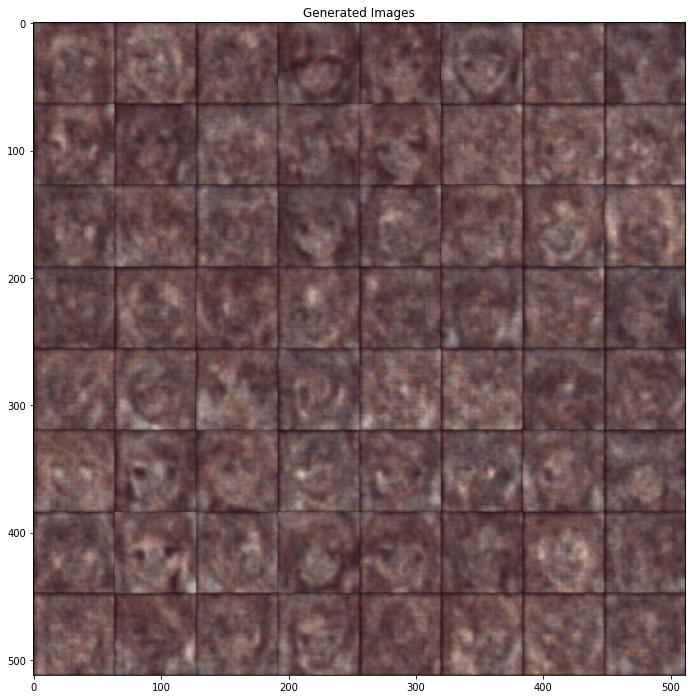

In [ ]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

### Save the Model

Once your satisfied with the results, please save and download the model. Afterwards, please go back to the Coursera submission portal to upload your h5 file to the autograder.

In [ ]:
vae.save("anime.h5")

In [ ]:
from google.colab import files
files.download('anime.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### KODINGAN SCRATCH GW < INI GA SESUAI SAMA SABMIT , SO PAHAMIN ae Logicnya >


Number of Batches in the Training Set : 26
Number of Batches in the Training Set : 7


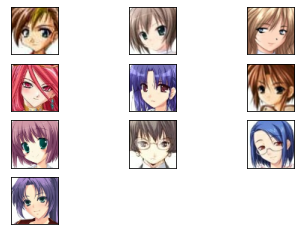

In [251]:
	#%%
	import tensorflow as tf
	import tensorflow_datasets as tfds

	import matplotlib.pyplot as plt
	import numpy as np

	import os
	import zipfile
	import random
	import urllib.request
	from IPython import display
	from typing import List,Tuple
	# set Seed
	SEED : int = 5
	np.random.seed(SEED)

	BATCH_SIZE : int = 2000
	LATENT_DIM : int = 512
	IMAGE_SIZE : int = 64	
	## For Typing
	Tensor = tf.Tensor
	Layer = tf.keras.layers.Layer
	Dataset = tf.data.Dataset
	Model = tf.keras.models.Model
	#%%
	try:
		os.mkdir("anime/")
	except OSError :
		pass

	#data_url : str = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"

	data_file_name : str = "animefaces.zip"
	download_dir : str = "anime/"

	with zipfile.ZipFile(data_file_name, "r") as zip_ref:
		zip_ref.extractall(download_dir)

	"""
		Utilities Functions
	"""
	#%%
	def get_dataset_slice_paths(image_dir : str) :
		image_file_list :List[str] = os.listdir(image_dir)
		image_paths : List[str] = [os.path.join(image_dir,file_name) for file_name in image_file_list]

		return image_paths

	def map_image(image_filename : str) -> Tensor:

		raw_image : Tensor = tf.io.read_file(image_filename)
		image : Tensor = tf.image.decode_jpeg(raw_image)
		image =  tf.image.convert_image_dtype(image, tf.float32)
		image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
		image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) 

		return image


	paths : str = get_dataset_slice_paths("/tmp/anime/images")

	random.shuffle(paths)

	paths_len : int = len(paths)
	train_paths_len : int = int(paths_len * 0.8)

	train_paths_list : List[str] = paths[:train_paths_len]
	val_paths_list : List[str] = paths[train_paths_len:]

	# Prepare the Training datasets
	training_dataset : Dataset = tf.data.Dataset.from_tensor_slices(train_paths_list)
	training_dataset = training_dataset.map(map_image).shuffle(1000).batch(BATCH_SIZE)

	# preprate the Validation Datasets
	validation_dataset : Dataset = tf.data.Dataset.from_tensor_slices(val_paths_list)
	validation_dataset = validation_dataset.map(map_image).batch(BATCH_SIZE)

	print(f"Number of Batches in the Training Set : {len(training_dataset)}")
	print(f"Number of Batches in the Training Set : {len(validation_dataset)}")

	def display_faces(dataset : Dataset , size : int =10):
		dataset = dataset.unbatch().take(size)
		ncols : int = 3
		nrows : int = size // ncols + 1
		i : int = 0
		for image in dataset:
			i += 1
			disp_image = np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
			plt.subplot(nrows, ncols, i)
			plt.yticks([])
			plt.xticks([])
			plt.imshow(disp_image)

	def display_one_row(disp_image : List[Tensor], offset : int, shape=(64,64)):
		for idx, image in enumerate(disp_image):
			plt.subplot(3, 10 , offset + idx+1)
			plt.yticks([])
			plt.xticks([])
			plt.imshow(image)


	def display_result(input_list, predicted_list)-> None:
		#TODO
		#todo Make your life easier dude 
		display_one_row(disp_image, 0, shape=(IMAGE_SIZE, IMAGE_SIZE,3))
		display_one_row(disp_image, 10, shape=(IMAGE_SIZE, IMAGE_SIZE,3))

	# %%
	display_faces(validation_dataset, size=10)

	#%%
	#TODO//
	#todo// CREATE Encoder Layer First
	#todo// CREATE Sampling Layer
	#todo// Integrate it into Encoder Model Cok 
	def encoder_model(input_shape , latent_dim):
		"""
		Create Encoder Model

		Args:
			input_shape (Tuple[int,int,int]): onlyShape
			latent_dim (int): Latent Dim units

		Returns:
			tf.keras.Model : Encoder Model
			vis_shape :  Shape before flattened
		"""
		inputs : Layer = tf.keras.layers.Input(shape=input_shape) #* Its Like Starting Point, Data Inputed

		mu, sigma, vis_shape = encoder_layers(inputs, latent_dim) #* This guys right here Will encode the input data

		z = Sampling_layer()([mu, sigma]) #* Feed The Mean and std, to calculate Z

		return tf.keras.Model(inputs, outputs= [mu,sigma,z]), vis_shape #*

	def encoder_layers(inputs : Tensor , latent_dim : int) -> Tuple[Tensor, Tensor, Tuple[int,int,int,int]]:

		"""
		Encoder layers,compute the mean and std of the latent vector

		Returns:
				Mu Tensor, sigma : Tensor, and vis.shape : Tuple
		"""
		#TODO
		#todo// 2 2 CNN, each having maxpooling ?
		#todo// Connect it to layer 
		#NOTE 
		#? BEFORE GOING TO LATENT SPACE, SAVE the previous Layer Shape, Fungsine Biar bisa dapet Total Represntasi yang dibutuhkan untuk rekonstruksi
		hidden_layer_1 : Tensor = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=2,activation=tf.nn.relu, padding="same",name="encoder_conv1")(inputs)
		hidden_layer_1 : Tensor = tf.keras.layers.BatchNormalization()(hidden_layer_1)
		hidden_layer_2 : Tensor = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2,activation=tf.nn.relu, padding="same",name="encoder_conv2")(hidden_layer_1);hidden_layer_3 : Tensor = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(hidden_layer_1)
		hidden_layer_2 : Tensor = tf.keras.layers.BatchNormalization()(hidden_layer_2)
		hidden_layer_3 : Tensor = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu',)(hidden_layer_2)
		vis : Tensor = tf.keras.layers.BatchNormalization(name="encoder_batchnorm1")(hidden_layer_3) #* YANG INI YA, di return

		fcn : Tensor = tf.keras.layers.Flatten(name="encoder_flatten")(vis)

		fcn : Tensor = tf.keras.layers.Dense(1024, activation=tf.nn.relu, name="encoder_dense1")(fcn) #* Using paper recommendation, 1024
		fcn : Tensor = tf.keras.layers.BatchNormalization()(fcn)

		mu : Tensor = tf.keras.layers.Dense(latent_dim, activation = "linear")(fcn) #* This shit is real
		sigma : Tensor = tf.keras.layers.Dense(latent_dim, activation= "linear")(fcn)
		
		return mu, sigma, vis.shape

	class Sampling_layer(tf.keras.layers.Layer):
		def call(self, inputs : Tensor) -> Tensor:
			mu : Tensor = inputs[0]
			sigma : Tensor = inputs[1]
			epsilon : Tensor = tf.keras.backend.random_normal(shape=tf.shape(mu))
			return mu + tf.exp(0.5* sigma) * epsilon


	#TODO
	#todo CREATE Decoder Layer First
	#NOTE
	#? OUTPUT LAYER NEED TO HAVE SAME SHAPE with INPUTS
	#? GW GANTENG .

	def decoder_layer(inputs : Tensor, conv_shape : Tuple[int,int,int,int])-> Tensor: 
		"""
		Rekonsturksi Image

		Args:
			inputs (Tensor): Z, from encoder, but already created the Input Layer
			conv_shape (Tuple[int,int,int,int]): : shape before flattened , used for reshaping

		Returns:
			Tranposed (Tensor) : Reconstructed Image
		"""

	#NOTE : #? inputs Berupa Laten Space , ini dari Encoder, Latent space ()
	#NOTE : #? Conv_shape isinya : (height, width, channel, filters)

	#todo// Ambil Seluruh Representasi dari si Z
	#todo// Reshape ke bentuk yang sama dengan input layer
	#todo Train dengan Konvolusi Transpose
		hidden_layer_1 : Tensor = tf.keras.layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation=tf.nn.relu,name="decoder_dense1")(inputs)
		hidden_layer_1 : Tensor = tf.keras.layers.BatchNormalization()(hidden_layer_1)
		reshaped_layer : Tensor = tf.keras.layers.Reshape(target_shape=(conv_shape[1],conv_shape[2], conv_shape[3]))(hidden_layer_1)
		
		transposed = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation=tf.nn.relu, padding="same",name="decoder_Tconv1")(reshaped_layer)
		
		transposed_normalized = tf.keras.layers.BatchNormalization()(transposed)
		transposed = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation=tf.nn.relu, padding="same",name="decoder_Tconv2")(transposed_normalized)
		
		transposed_normalized = tf.keras.layers.BatchNormalization()(transposed)
		transposed = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation=tf.nn.relu, padding="same",name="decoder_Tconv3")(transposed_normalized)
		
		transposed_normalized = tf.keras.layers.BatchNormalization()(transposed)
		transposed = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=1, activation=tf.nn.sigmoid, padding="same",name="decoder_Tconv4")(transposed_normalized)
	
	
		return transposed
	def decoder_model(latent_dim, conv_shape) :
		"""
		Decoder Model , Just Integrate stuff for creating model

		Args:
			latent_dim ([Tensor]): its for input layer of decoder, From dense Layer
			conv_shape ([Tuple[int,int,int,int]]): shape before flattened, used for reshaping

		Returns:
			Model : Decoder Model
		"""
		inputs : Layer = tf.keras.layers.Input(shape=latent_dim) #* This guy here is the input layer, Z
		outputs : Layer = decoder_layer(inputs, conv_shape)
		return tf.keras.Model(inputs, outputs)

	def k1_reconstruction_loss(inputs : Tensor , outputs : Tensor, mu : Tensor, sigma : Tensor):
		"""
		Reconstruction Loss

		Args:
			inputs (Tensor): Inputs from the original image
			outputs (Tensor): Outputs from the decoder,i.e Reconstruced Image
			mu (Tensor): Mean of the latent vector
			sigma (Tensor): Std of the latent vector
		"""
		k1_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
		k1_loss = tf.reduce_mean(k1_loss) * -0.5

		return k1_loss

	def vae(encoder : Model, decoder:Model, input_shape:Model):
		"""
		VAE Model

		Args:
			encoder (Model): Yeah the Model
			decoder (Model): [description]
			input_shape (Model): Input Shape From the original Image

		Returns:
			Model With Configured Loss 
		"""

		input_layer : Layer = tf.keras.layers.Input(shape=input_shape)
		mu, sigma, z  = encoder(input_layer) #*	 This is not encoder layers, but the output of encoder model 
		reconstructed = decoder(z)

		model = tf.keras.models.Model(inputs = input_layer, outputs=reconstructed)

		loss = k1_reconstruction_loss(input_layer, z, mu, sigma)
		model.add_loss(loss)
		return model

	def get_models(input_shape, latent_dim):
		encoder, conv_shape = encoder_model(input_shape, latent_dim)
		decoder = decoder_model(latent_dim, conv_shape)
		vae_model = vae(encoder, decoder, input_shape=input_shape)

		return encoder, decoder, vae_model 


	#TODO PREPARE THE MODELS 
	encoder, decoder, vae = get_models(input_shape=(64,64,3), latent_dim=LATENT_DIM)
	#TODO
	#// Settingup the optmizers
	#// Settingup The Metrics

	optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
	loss_metric = tf.keras.metrics.Mean()  #* We only need how good our model reconstructed the models, So we use Mean
	mse_loss = tf.keras.losses.MeanSquaredError() #* This guys here, is for Vae LOSS, this is calculated from the constructed and the real
	bce_loss = tf.keras.losses.BinaryCrossentropy() #* This guys here, Same as above, mse, but here using different equation. 

	def generate_and_save_images(model : Model, epochs : int, step : int, test_input):

		predictions = model.predict(test_input)

		fig = plt.figure(figsize=(4, 4))

		for i in range(predictions.shape[0]): #* We need to loop for the number of images, Batch
			plt.subplot(4, 4, i+1)
			img = predictions[i, :,:,:] * 255
			img = img.astype(np.int32)
			plt.imshow(img)
			plt.axis("off")
		
		fig.suptitle("Epochs : {} , Step : {}".format(epochs, step))
		plt.savefig("image_at_epoch_{:04d}_step_{:04d}.png".format(epochs, step))
		plt.show()




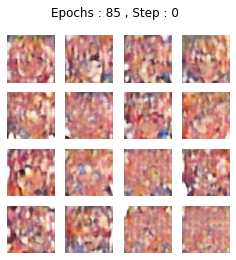

Epoch 85 step 0 mean loss = 231.699462890625


KeyboardInterrupt: ignored

In [252]:
EPOCHS : int = 100

random_vector_noise : Tensor = tf.random.normal(shape=(16, LATENT_DIM)) #* Just For Visualization
generate_and_save_images(decoder, 0, 0, random_vector_noise)

for epoch in ran ge(EPOCHS):
	print(f"Start Epoch {epoch}")

	for step, x_batch_train in enumerate(training_dataset):
		with tf.GradientTape() as tape:

				reconstructed = vae(x_batch_train)

				flattened_inputs : Tensor = tf.reshape(x_batch_train,shape=(-1)) # Flattened IT
				flattened_reconstructed : Tensor = tf.reshape(reconstructed,shape=(-1)) # Flattened ITms
				loss = mse_loss(flattened_inputs, flattened_reconstructed) * 64*64*3 #* Loss is calculated from the constructed and the real ,multiplied by all pixels , for total loss of all pixels

				loss = loss + sum(vae.losses)

				#* Calculating the gradients
		gradients = tape.gradient(loss, vae.trainable_weights)
		optimizer.apply_gradients(zip(gradients, vae.trainable_weights))

		loss_metric(loss)

		if step % 10 == 0:
			display.clear_output(wait=False)
			generate_and_save_images(decoder, epoch, step, random_vector_noise)
			print(f"Epoch {epoch} step {step} mean loss = {loss_metric.result().numpy()}")

In [223]:
encoder.summary()

Model: "model_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv1 (Conv2D)          (None, 32, 32, 32)   896         input_93[0][0]                   
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 32, 32, 32)   128         encoder_conv1[0][0]              
__________________________________________________________________________________________________
encoder_conv2 (Conv2D)          (None, 16, 16, 64)   18496       batch_normalization_83[0][0]     
___________________________________________________________________________________________

In [254]:
vae.save("anime_.h5")